<a href="https://colab.research.google.com/github/Imran123885/InspiritAI_work/blob/main/imran_mirza_student_objectdetection_section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we'll be:
1.   Implementing the Sliding Window Algorithm
2.   Performing Vehicle Recognition Prediction on Sliding Windows
3.   Exploring Convolutional Neural Networks
4.   Exploring Transfer Learning


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
!pip install scikeras > /dev/null

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from scikeras.wrappers import KerasClassifier
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121

from PIL import Image
import gdown
from IPython import display

!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image-2.jpg"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/sliding.gif.png"

# Show sliding windows
def show_sliding_window():
  return display.Image(filename="sliding.gif.png")

# Construct vehicle dataset
label_car = 1
label_truck = 9

# Load data
def load_cifar10():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)

  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)

  return new_data, new_labels

def load_vehicle_dataset():
  (X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = load_cifar10()
  X_train, y_train = construct_vehicle_dataset(X_train_cifar, y_train_cifar, 5000)
  X_test, y_test = construct_vehicle_dataset(X_test_cifar, y_test_cifar, 1000)
  return (X_train, y_train), (X_test, y_test)

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None, fig_size=None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  if fig_size is not None:
    plt.figure(figsize=fig_size)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry.
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
  ax.legend(loc = 1)
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')

  plt.show()


def TransferClassifier_func(name, nn_params, trainable = True):
  expert_dict = {'VGG16': VGG16,
                  'VGG19': VGG19,
                  'ResNet50':ResNet50,
                  'DenseNet121':DenseNet121}

  expert_conv = expert_dict[name](weights = 'imagenet',
                                            include_top = False,
                                            input_shape = nn_params['input_shape'])
  for layer in expert_conv.layers:
    layer.trainable = trainable

  expert_model = Sequential()
  expert_model.add(expert_conv)
  expert_model.add(GlobalAveragePooling2D())

  expert_model.add(Dense(128, activation = 'relu'))
  expert_model.add(Dropout(0.3))

  expert_model.add(Dense(64, activation = 'relu'))

  expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

  expert_model.compile(loss = nn_params['loss'],
                optimizer = optimizers.SGD(learning_rate=nn_params['learning_rate'], momentum=nn_params['momentum']),
                metrics=['accuracy'])

  return expert_model

# neural net parameters
image_shape          = (32, 32, 3)
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 3
nn_params['loss']              = 'categorical_crossentropy'
nn_params['output_activation'] = 'softmax'
nn_params['learning_rate'] = 1e-3
nn_params['momentum'] = 0.9

TransferClassifier  = lambda name: TransferClassifier_func(name = name, nn_params = nn_params);

image-2.jpg         100%[===================>]   5.05K  --.-KB/s    in 0s      
image2.jpg          100%[===================>]  77.28K   376KB/s    in 0.2s    
sliding.gif.png     100%[===================>]   3.03M  2.39MB/s    in 1.3s    


We're going to train some models that are a bit more complicated than a perceptron, so make sure you are using GPU by running the following code.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Today, we will be working with the following image, which we will apply objection detection to.

(100, 160, 3)
Label: 


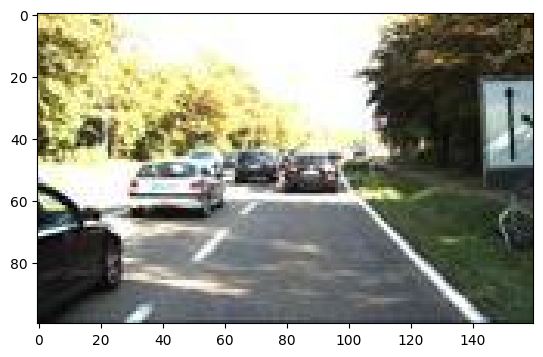

In [ ]:
import numpy as np

image = np.asarray(Image.open('./image-2.jpg'))
print(image.shape)
plot_one_image(image)

# Milestone 1. Implementing the sliding window algorithm

Remember our discussion about how to solve the object detection problem?

We broke the problem into 2 parts, localization and recognition.

We already have an image classifier for vehicle recognition now, so how can we make use of this image classifier for object detection?

One naive method is to apply the classifier on sliding windows of the input image.

As you can see from the gif above, the sliding window technique involves sliding through the image, looking at cropped images of a fixed size.

To implement this sliding window algorithm, let's first figure out how to crop an image.



### Exercise (Coding) | Image Cropping

You've probably used an image crop before, where you segment part of an image out, like below:

![](https://drive.google.com/uc?export=view&id=1EAw4z5a96OvL77jNAf9v6f7ItvUaGFGm)

How can we implement this in Python?

In [ ]:
# first copy our image... Make sure to copy it! Otherwise, we may accidentally overwrite our original image.
new_image = image.copy()
print(new_image.shape)

(100, 160, 3)


In [ ]:
#@title What does the image's shape represent? { display-mode: "form" }

#@markdown What does the bold number (**100**, 160, 3) represent?
Dimension_0  = "image height" #@param ["number of images", "image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (100, **160**, 3) represent?
Dimension_1  = "fill in" #@param ["number of images", "image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (100, 160, **3**) represent?
Dimension_2  = "fill in" #@param ["number of images", "image width", "image height","number of colors","fill in"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")

if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Try again for Dimension_1!
Try again for Dimension_2!


We want to get a rectangle crop whose top left corner is at `(x, y)` of the image. The height and width of the cropping window is `window_h` and `window_w` respectively. Can you implement this on the `new_image` and plot your result?


(32, 48, 3)
Label: 


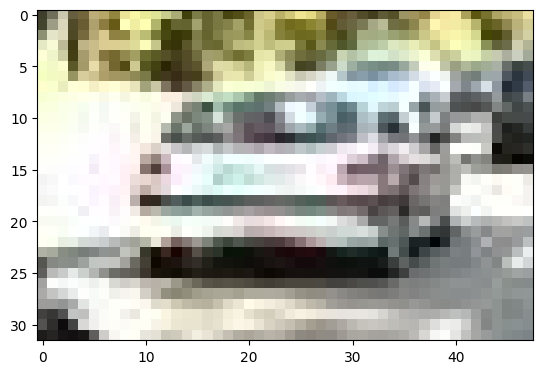

In [ ]:
x = 20
y = 40
window_h = 32
window_w = 48

### YOUR CODE HERE
cropped_image = new_image[y:y+window_h, x:x+window_w, :]
print(cropped_image.shape)
plot_one_image(cropped_image)
### END CODE

### Exercise (Coding) | Sliding Windows

The sliding windows are crops at multiple `(x, y)` positions. To get the sliding windows, we can just iterate through `(x, y)` positions and do the cropping as what we did above.

Next, let's add a for loop to get our sliding windows!

Label: 


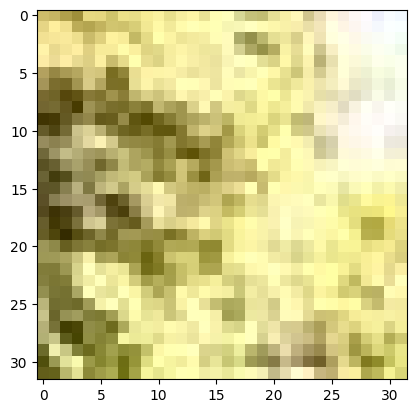

Label: 


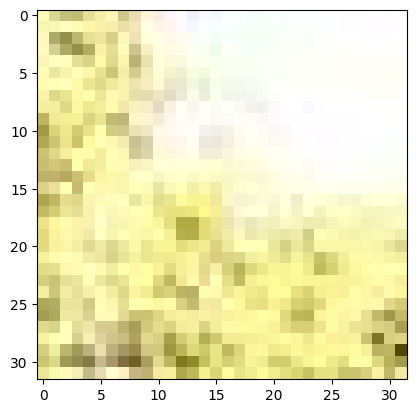

Label: 


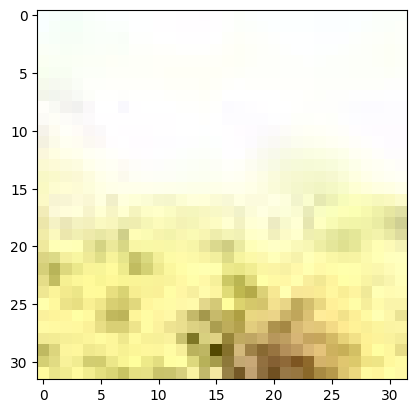

Label: 


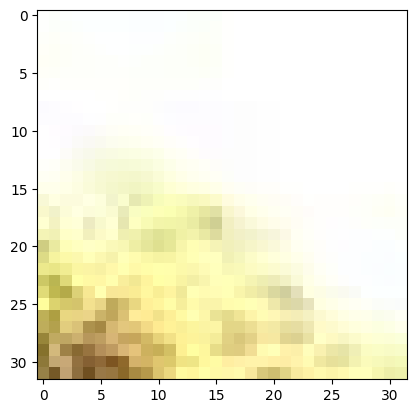

Label: 


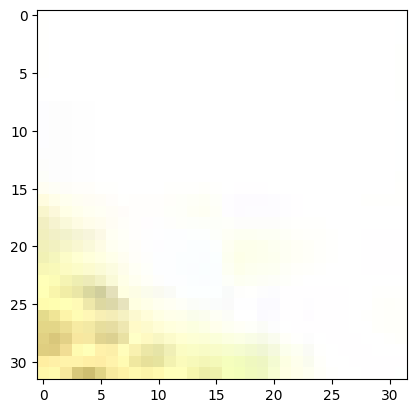

Label: 


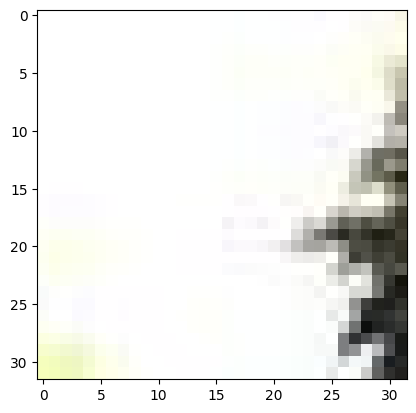

Label: 


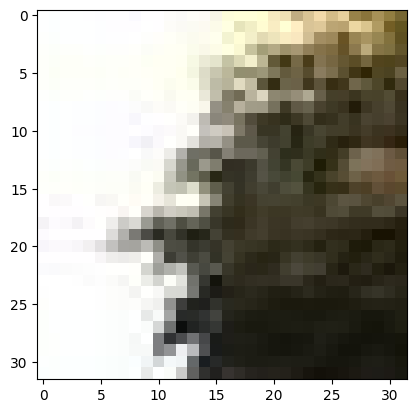

Label: 


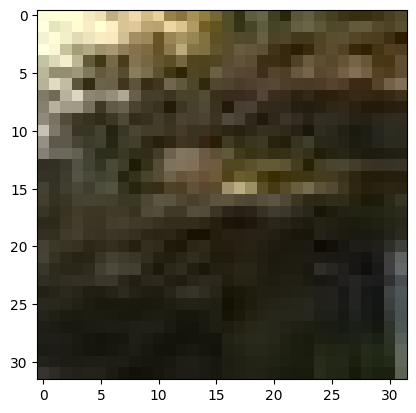

Label: 


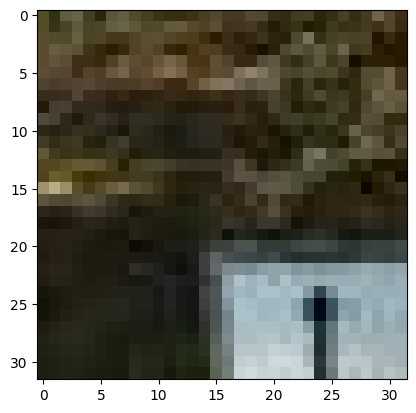

Label: 


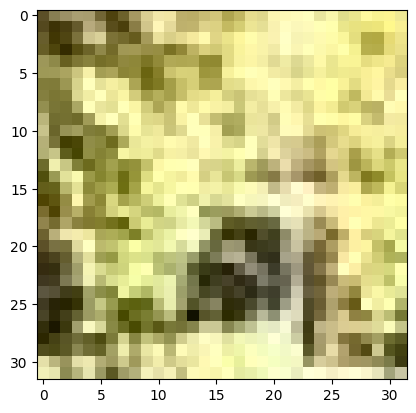

Label: 


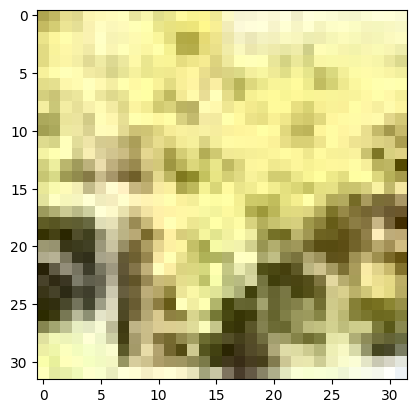

Label: 


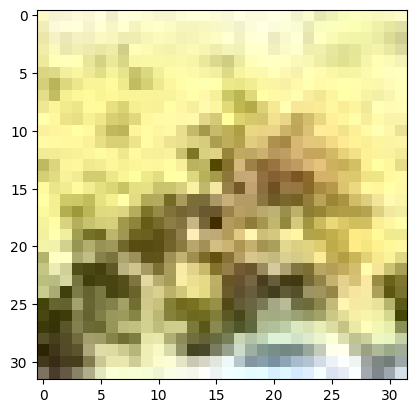

Label: 


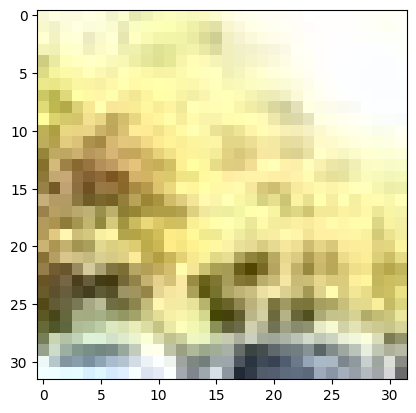

Label: 


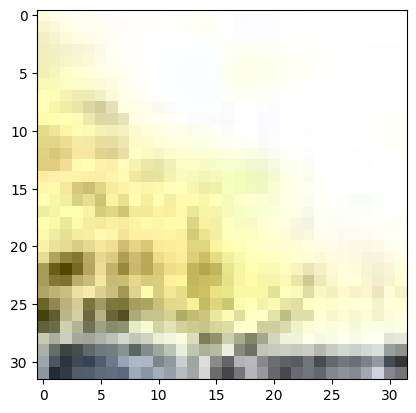

Label: 


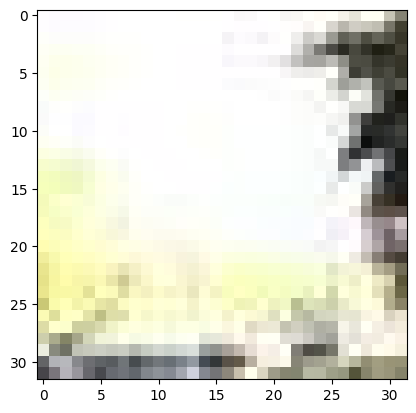

Label: 


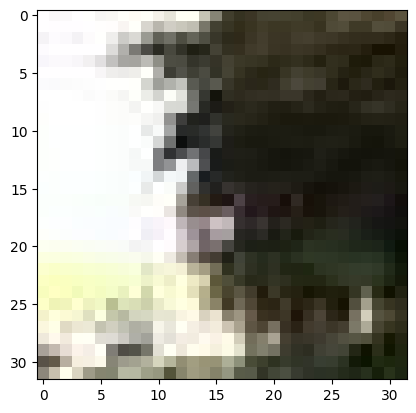

Label: 


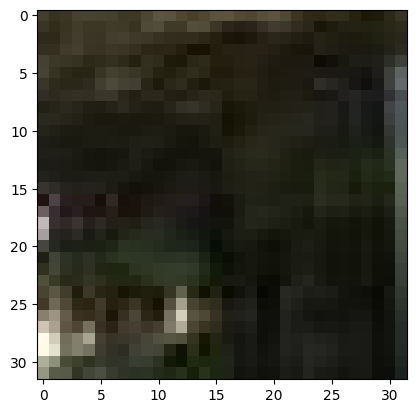

Label: 


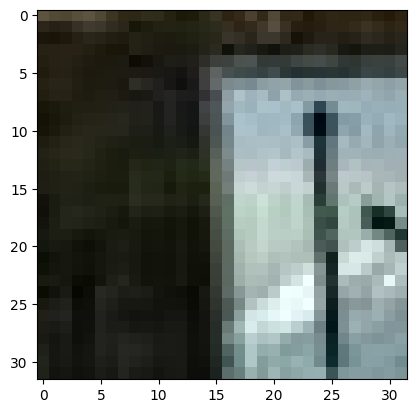

Label: 


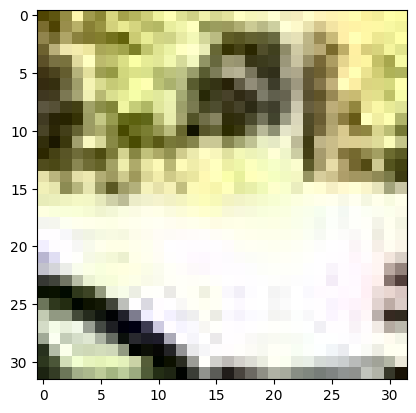

Label: 


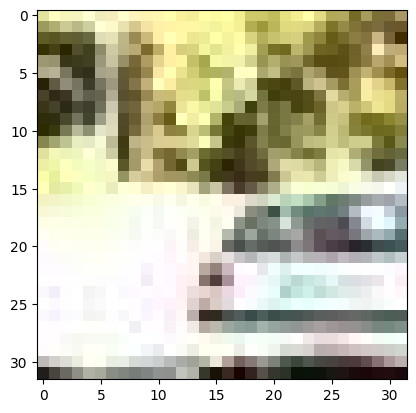

Label: 


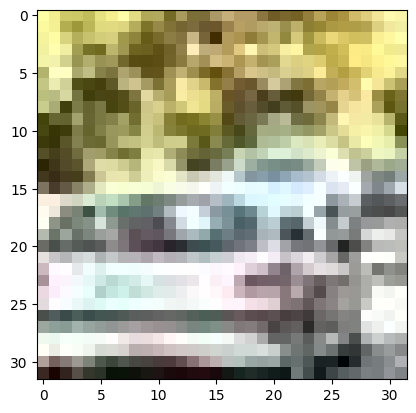

Label: 


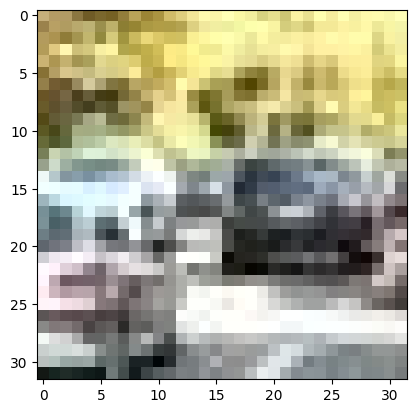

Label: 


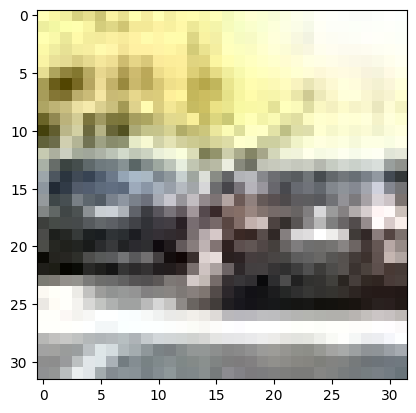

Label: 


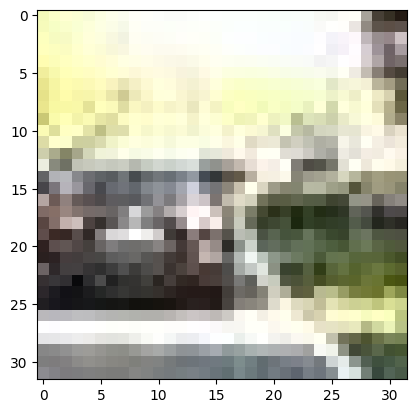

Label: 


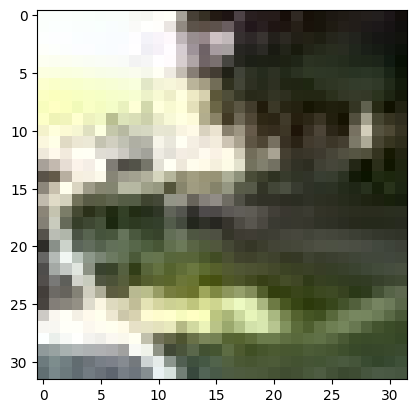

Label: 


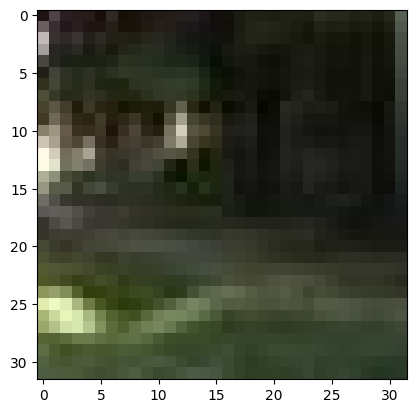

Label: 


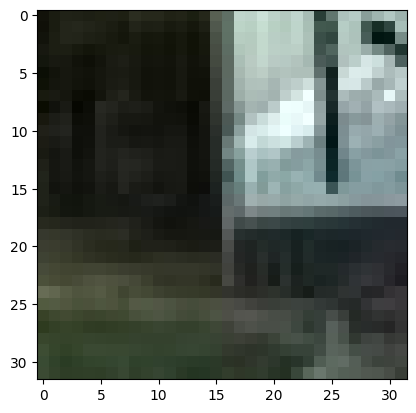

Label: 


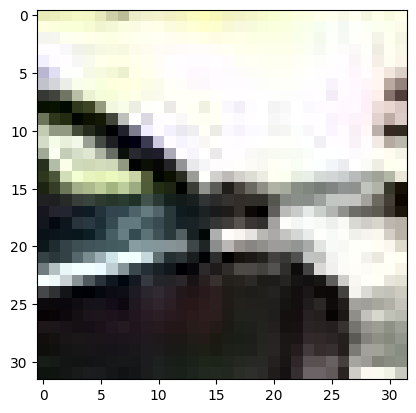

Label: 


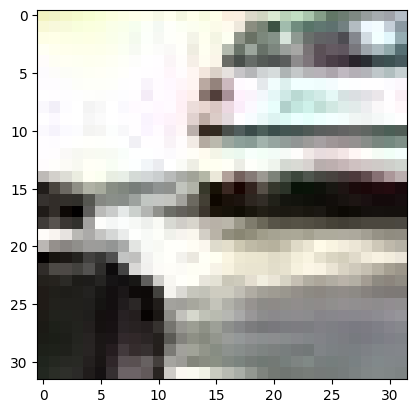

Label: 


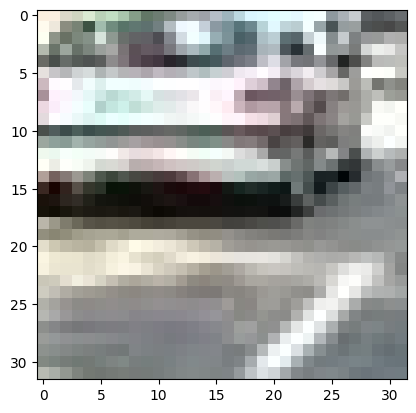

Label: 


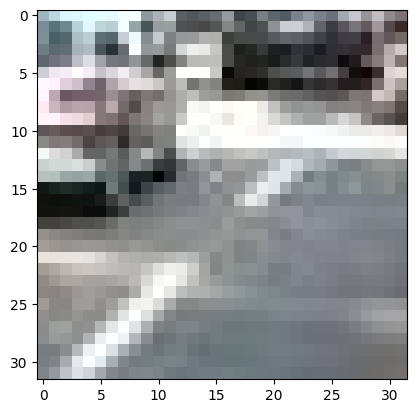

Label: 


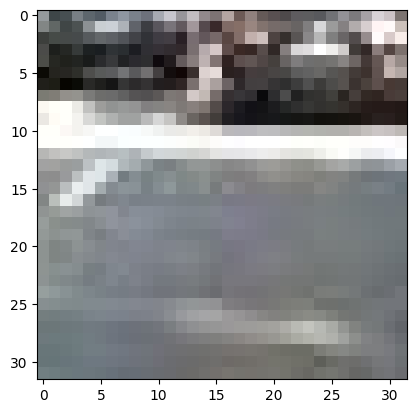

Label: 


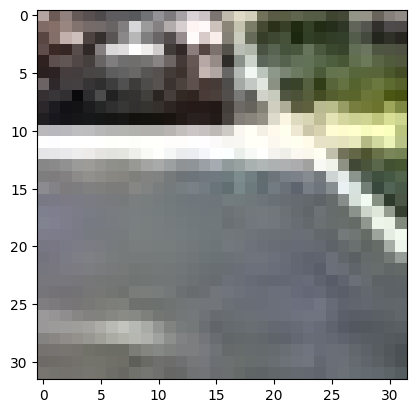

Label: 


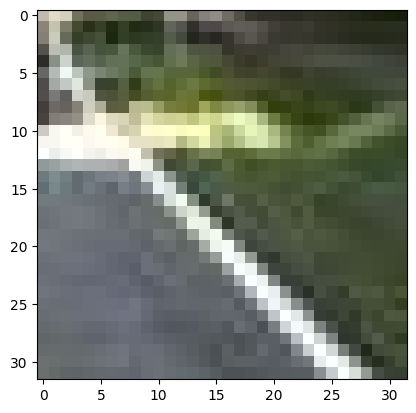

Label: 


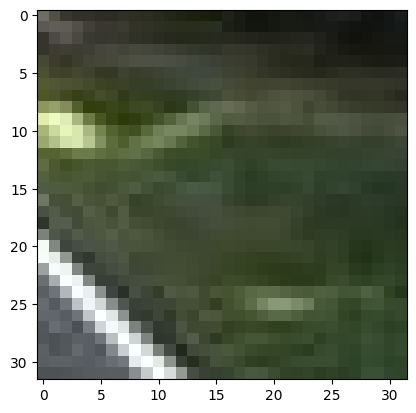

Label: 


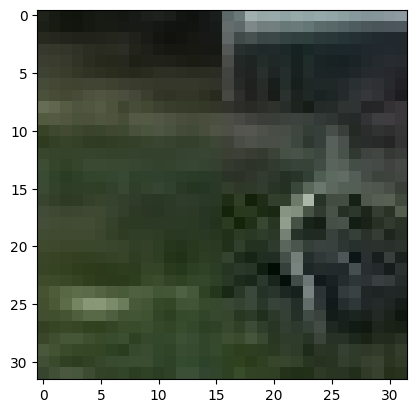

Label: 


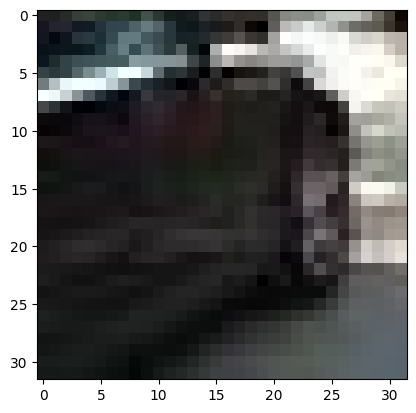

Label: 


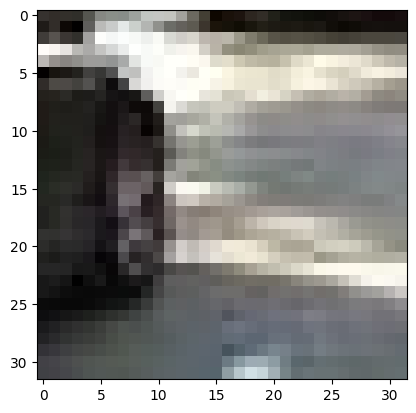

Label: 


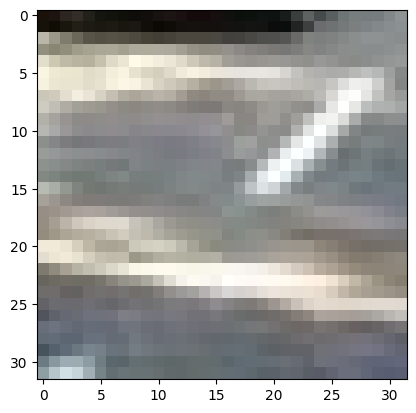

Label: 


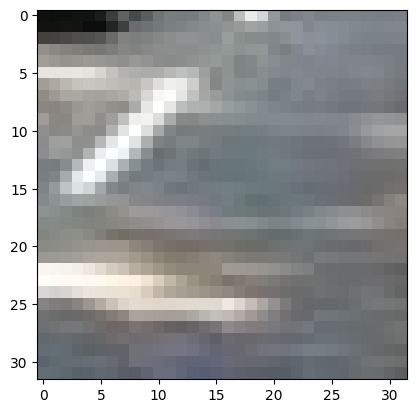

Label: 


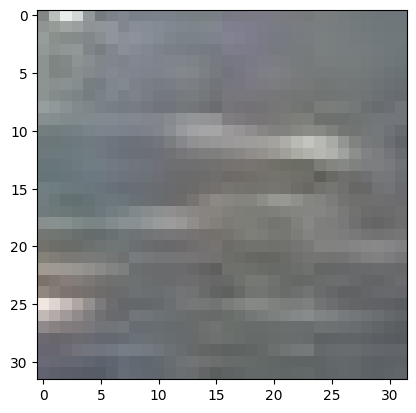

Label: 


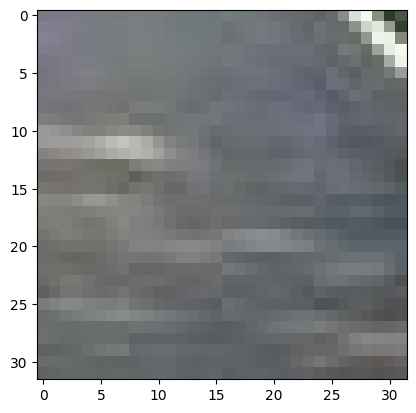

Label: 


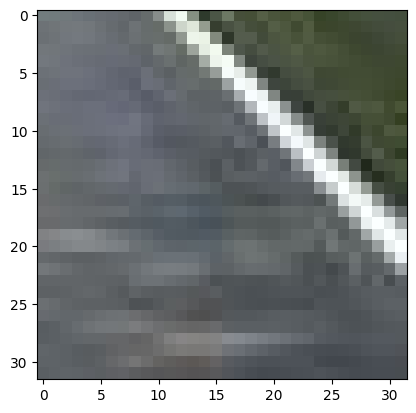

Label: 


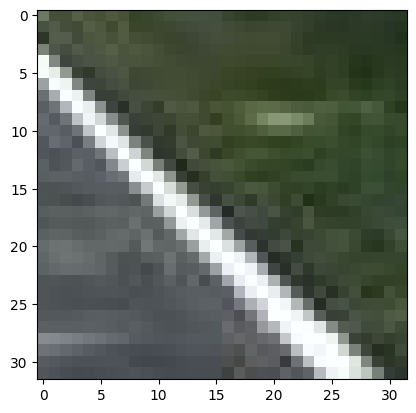

Label: 


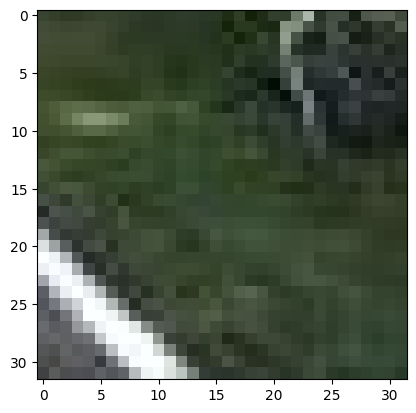

In [ ]:
step_h = 16
step_w = 16
window_h = 32
window_w = 32

# Save your results in this list
windows = []

### YOUR CODE HERE
for x in range(0, new_image.shape[0], step_h):
  for y in range(0, new_image.shape[1], step_w):
    window = new_image[x:x+window_h, y:y+window_w]
    if window.shape[0] == 32 and window.shape[1] == 32:
      plot_one_image(window)
      windows.append(window)

### END CODE

In [ ]:
#@title Run this to test if your code is right!

count = 0
for w in windows:
  if w.shape != (window_h, window_w, 3):
    count += 1
if count != 0:
  print("Please check again. Some of your windows are not the correct size of ({}, {}, 3)".format(window_h, window_w))
else:
  print("All the windows are the correct size! Well done!")

if len(windows) == 45:
  print("You got the correct number of windows! Well done!")
else:
  print("Please check again. The number of windows is wrong.")

All the windows are the correct size! Well done!
You got the correct number of windows! Well done!


Recall that the label and class name mapping is
```
0 - background
1 - car
2 - truck
```
We have created labels for the windows in advance, as defined below. Now let's plot all the windows and their labels to check what you've got! Hopefully, the labels look reasonable to you.

In [ ]:
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0])

Label: [0]


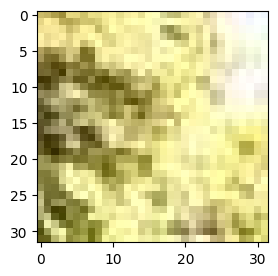

Label: [0]


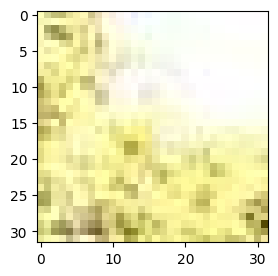

Label: [0]


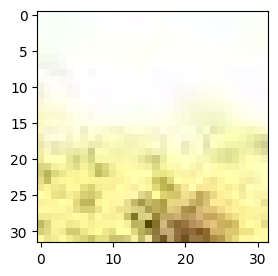

Label: [0]


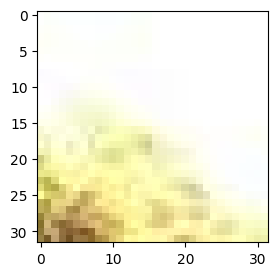

Label: [0]


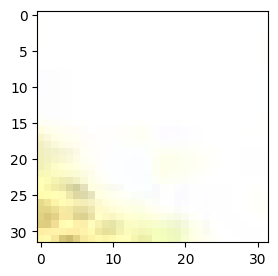

Label: [0]


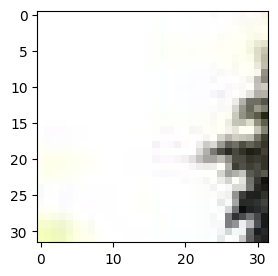

Label: [0]


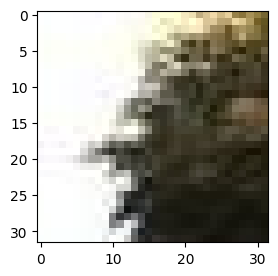

Label: [0]


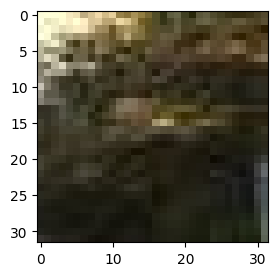

Label: [0]


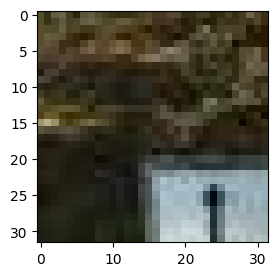

Label: [0]


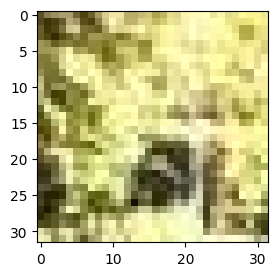

Label: [0]


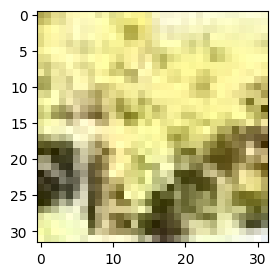

Label: [0]


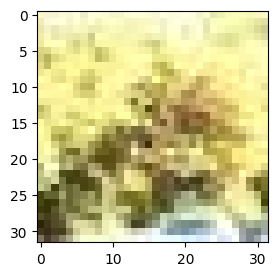

Label: [0]


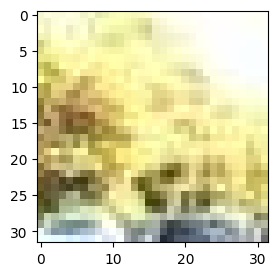

Label: [0]


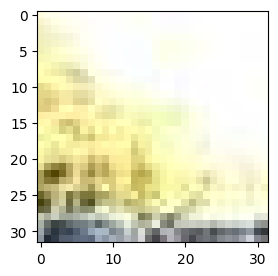

Label: [0]


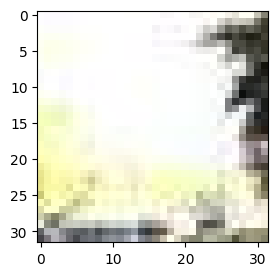

Label: [0]


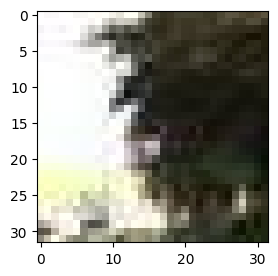

Label: [0]


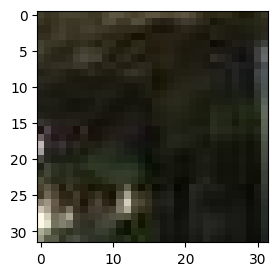

Label: [0]


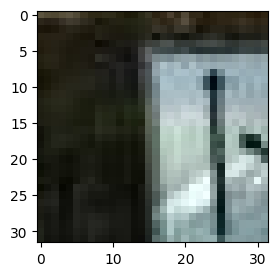

Label: [0]


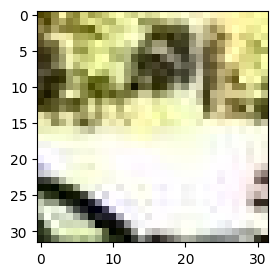

Label: [1]


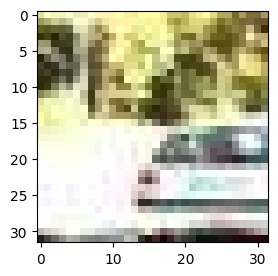

Label: [1]


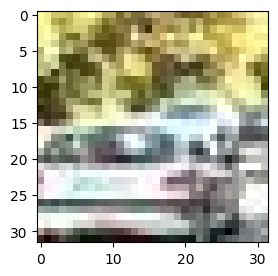

Label: [1]


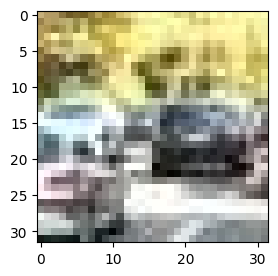

Label: [1]


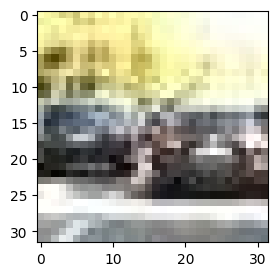

Label: [1]


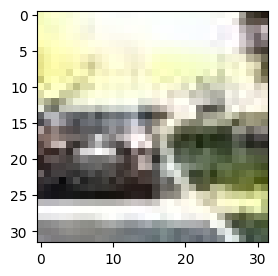

Label: [0]


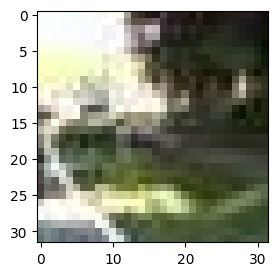

Label: [0]


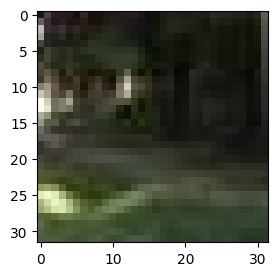

Label: [0]


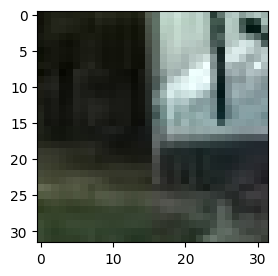

Label: [1]


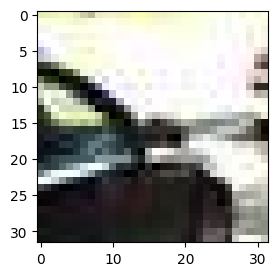

Label: [1]


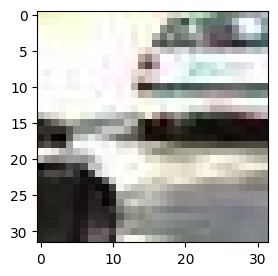

Label: [1]


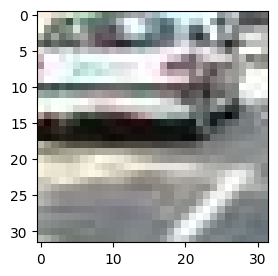

Label: [1]


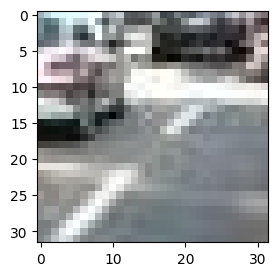

Label: [1]


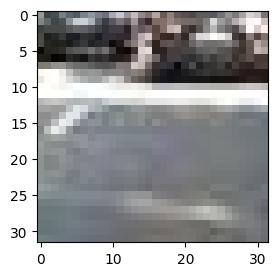

Label: [1]


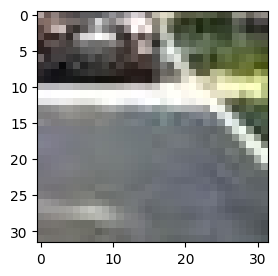

Label: [0]


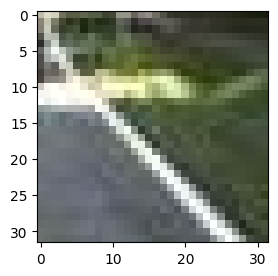

Label: [0]


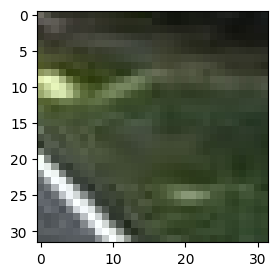

Label: [0]


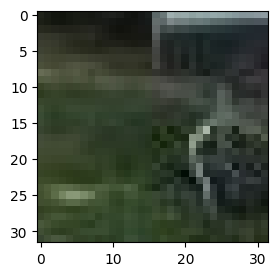

Label: [1]


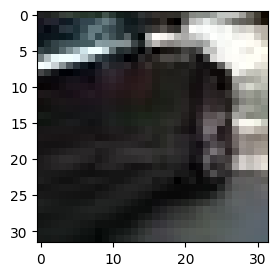

Label: [0]


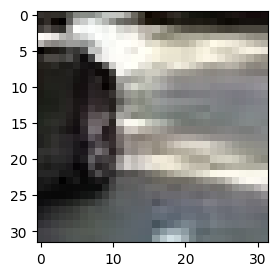

Label: [0]


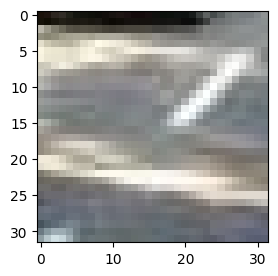

Label: [0]


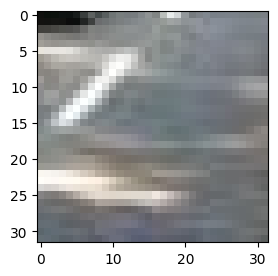

Label: [0]


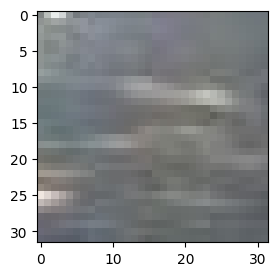

Label: [0]


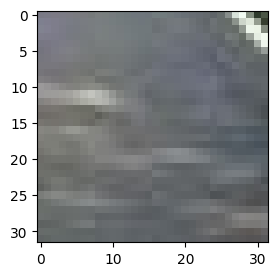

Label: [0]


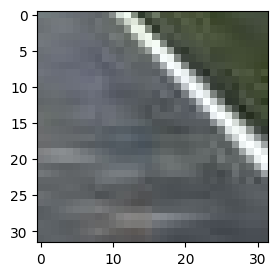

Label: [0]


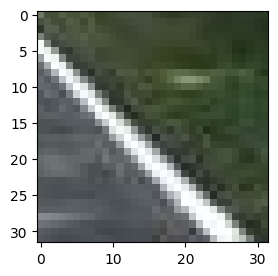

Label: [0]


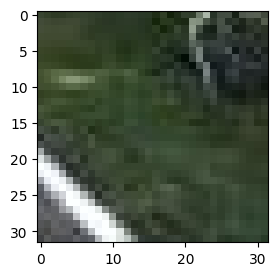

In [ ]:
for window, label in zip(windows, labels):
  plot_one_image(window, [label], fig_size=(3,3))

Recall that the inputs to our neural network models are `numpy` arrays, we need to convert our `windows` list to a `numpy` array. You can do this using the numpy function stack. Since we import numpy under the alias np, we can call it using `np.stack()`.

This will join a sequence of same dimension arrays along a new axis, combining all our windows into one numpy object. Check if the shape of the result array is what you expect!





In [ ]:
import numpy as np

### YOUR CODE HERE
windows_array = np.stack(windows)
windows_array, windows_array.shape
### END CODE

(array([[[[205, 188, 106],
          [198, 181,  99],
          [176, 160,  75],
          ...,
          [238, 240, 252],
          [248, 252, 255],
          [242, 249, 255]],
 
         [[230, 213, 133],
          [255, 239, 157],
          [241, 224, 142],
          ...,
          [245, 248, 253],
          [251, 255, 255],
          [249, 255, 255]],
 
         [[242, 225, 147],
          [247, 230, 152],
          [249, 233, 155],
          ...,
          [250, 253, 246],
          [251, 255, 251],
          [244, 254, 246]],
 
         ...,
 
         [[108, 107,  43],
          [240, 239, 174],
          [200, 199, 132],
          ...,
          [220, 215, 123],
          [204, 201, 106],
          [233, 230, 137]],
 
         [[ 80,  79,  12],
          [154, 154,  84],
          [226, 226, 154],
          ...,
          [143, 139,  42],
          [196, 194,  94],
          [232, 229, 132]],
 
         [[ 99,  94,  26],
          [101,  98,  27],
          [185, 183, 109],
   

# Milestone 2. Vehicle Recognition Prediction on Sliding Windows

Once we have the patches of the cropped image saved in the numpy array `windows`, we can now apply the perceptron that we trained to recognize cars.

As what we did exactly, let's load the vehicle dataset, build the perceptron model and train it on the dataset!

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Load data
(X_train, y_train), (X_test, y_test) = load_vehicle_dataset()

In [ ]:
# Build model
perceptron = Sequential()
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))

perceptron.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                   metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.8654 - accuracy: 0.6339 - val_loss: 0.7665 - val_accuracy: 0.6853
Epoch 2/20
 52/469 [==>...........................] - ETA: 1s - loss: 0.6631 - accuracy: 0.7308

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 2s 4ms/step - loss: 0.6686 - accuracy: 0.7221 - val_loss: 0.7041 - val_accuracy: 0.7060
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.6014 - accuracy: 0.7539 - val_loss: 0.7200 - val_accuracy: 0.7103
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.5536 - accuracy: 0.7773 - val_loss: 0.7223 - val_accuracy: 0.7007
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.5108 - accuracy: 0.7977 - val_loss: 0.6845 - val_accuracy: 0.7197
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4788 - accuracy: 0.8131 - val_loss: 0.7266 - val_accuracy: 0.7160
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4350 - accuracy: 0.8309 - val_loss: 0.7167 - val_accuracy: 0.7210
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.4070 - accuracy: 0.8457 - val_loss: 0.7303 - val_accuracy: 0.7130
Epoch 9/20
469/46

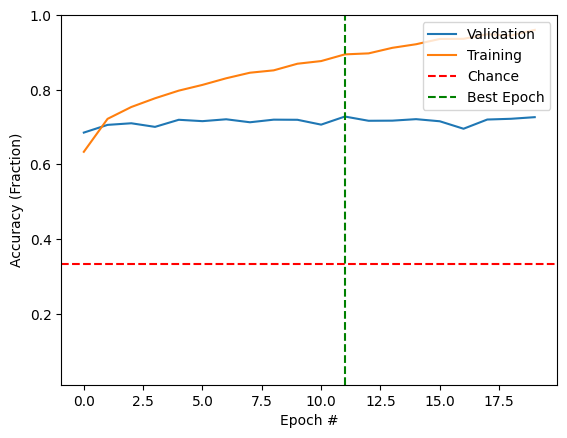

In [ ]:
# Preprocess data
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

# Train the model
history = perceptron.fit(X_train_norm, y_train_onehot, epochs=20, validation_data=(X_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])

plot_acc(history)

Our perceptron model can recognize cars and trucks at around 95% accuracy on the training set and around 72% accuracy on the test set! Although it's not perfect, it's already capable of recognizing cars to some degree.

Now that we have both the sliding windows and the trained model, let's try to combine these two to create a simple vehicle detector!


### Exercise (Coding) | Prediction on Sliding Windows


Given the sliding windows `windows`, we want to get the `perceptron`'s predictions `y_pred` on whether each patch contains a car/truck or not. We also want to get the model's confidence `pred_prob` about the prediction.

Hints:

* Don't forget to `normalize` the input data before feeding it into the model
* To get the model's outputs for the inputs, we use `perceptron.predict(input_data)`.
* The output of the model is the predicted probability over the 3 classes: car, truck and others. For each input image, the model chooses the predicted class to be the one with the highest probability. That probability is regarded as the model's confidence on this prediction.
* [`np.max()`](https://numpy.org/doc/stable/reference/generated/numpy.max.html) and [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) may be useful.


In [ ]:
### YOUR CODE HERE

XW = normalize(windows_array)
initial_pred = perceptron.predict(XW)
y_pred_probs = np.max(initial_pred, axis=1)
y_pred = initial_pred.argmax(axis=1)
y_pred_probs, y_pred, y_pred_probs.shape, y_pred.shape
### END CODE

2/2 [==============================] - 0s 5ms/step


(array([0.96381485, 0.99647635, 0.98901635, 0.9996834 , 0.99181014,
        0.9997228 , 0.9371584 , 0.9746606 , 0.99837387, 0.8346956 ,
        0.9999074 , 0.9954189 , 0.98909503, 0.97259694, 0.8143689 ,
        0.9894667 , 0.9905682 , 0.9999995 , 0.9488211 , 0.99553525,
        0.9960033 , 0.9994324 , 0.99515   , 0.99977285, 0.58334017,
        0.9766792 , 0.9415227 , 0.8670087 , 0.7602939 , 0.96559304,
        0.68248975, 0.8163575 , 0.9997694 , 0.50344837, 0.99708706,
        0.9005259 , 0.9969702 , 0.6809596 , 0.83415127, 0.93248767,
        0.6389758 , 0.8335995 , 0.992957  , 0.98150164, 0.91564035],
       dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2,
        2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
        0]),
 (45,),
 (45,))

In [ ]:
for i in XW:
  print(i.shape)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


Now we have our results saved in `y_pred` and `pred_prob`. To better understand how our model is doing, let's plot the detected cars and trucks!

We can set a confidence `threshold`, so that only the predictions that have higher confidence than the given `threshold` will be plotted.

Can you fill in the if condition below, to only plot the windows that are recognized to be car/truck and with a higher prediction confidence than the given `threshold`?

Recall that the label and class name mapping is
```
0 - background
1 - car
2 - truck
```

Label: ['0 0.96381485']


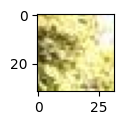

Label: ['0 0.99647635']


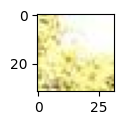

Label: ['0 0.98901635']


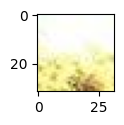

Label: ['0 0.9996834']


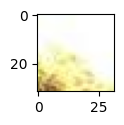

Label: ['0 0.99181014']


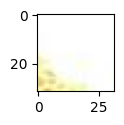

Label: ['0 0.9997228']


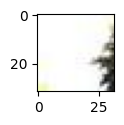

Label: ['0 0.9371584']


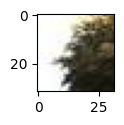

Label: ['0 0.9746606']


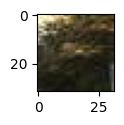

Label: ['0 0.99837387']


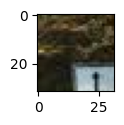

Label: ['0 0.8346956']


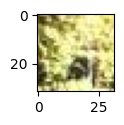

Label: ['0 0.9999074']


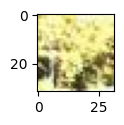

Label: ['0 0.9954189']


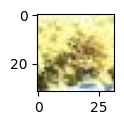

Label: ['0 0.98909503']


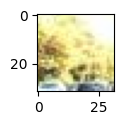

Label: ['0 0.97259694']


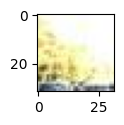

Label: ['2 0.8143689']


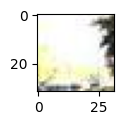

Label: ['0 0.9894667']


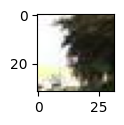

Label: ['0 0.9905682']


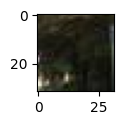

Label: ['0 0.9999995']


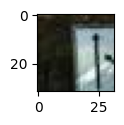

Label: ['1 0.9488211']


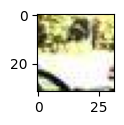

Label: ['0 0.99553525']


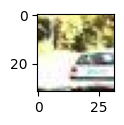

Label: ['0 0.9960033']


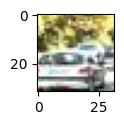

Label: ['2 0.9994324']


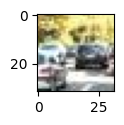

Label: ['2 0.99515']


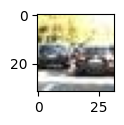

Label: ['2 0.99977285']


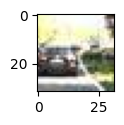

Label: ['0 0.9766792']


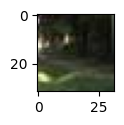

Label: ['0 0.9415227']


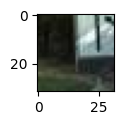

Label: ['0 0.8670087']


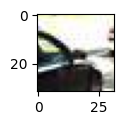

Label: ['1 0.7602939']


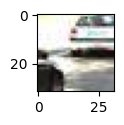

Label: ['1 0.96559304']


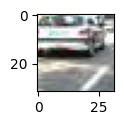

Label: ['0 0.68248975']


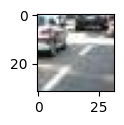

Label: ['1 0.8163575']


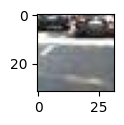

Label: ['1 0.9997694']


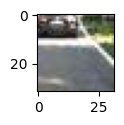

Label: ['0 0.99708706']


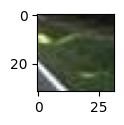

Label: ['0 0.9005259']


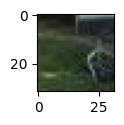

Label: ['0 0.9969702']


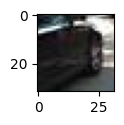

Label: ['0 0.6809596']


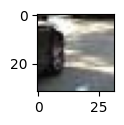

Label: ['1 0.83415127']


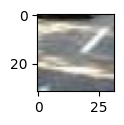

Label: ['1 0.93248767']


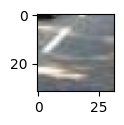

Label: ['0 0.6389758']


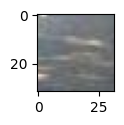

Label: ['0 0.8335995']


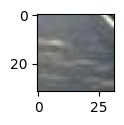

Label: ['1 0.992957']


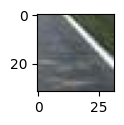

Label: ['0 0.98150164']


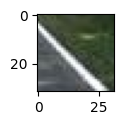

Label: ['0 0.91564035']


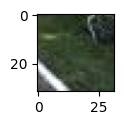

In [ ]:
threshold = 0.6
num_windows = windows_array.shape[0]
for i in range(num_windows):
  ### YOUR CODE HERE
  if y_pred_probs[i] >= threshold:
  ### END CODE
    plot_one_image(windows[i], labels=[" ".join([str(y_pred[i]), str(y_pred_probs[i])])], fig_size=(1,1))

We can also calculate the accuracy of our predictions by comparing the predictions and the labels.

In [ ]:
np.mean(y_pred == labels)

0.6888888888888889

In order to reuse the code easily, let's include the prediction, plotting and calculating accuracy in one function, which returns the accuracy.

In [ ]:
def sliding_predictions(model, windows, threshold=0.6, labels=labels):
  ### Copy the prediction code here
  XW = normalize(windows)
  initial_pred = perceptron.predict(XW)

  y_pred_probs = np.max(initial_pred, axis=1)
  y_pred = initial_pred.argmax(axis=1)
  ### Copy the plotting code here
  threshold = 0.6

  num_windows = windows.shape[0]
  for i in range(num_windows):
    if y_pred_probs[i] >= threshold:
      plot_one_image(windows[i], labels=[" ".join([str(y_pred[i]), str(y_pred_probs[i])])], fig_size=(1,1))
  ### Return the accuracy
  return np.mean(y_pred==labels)

2/2 [==============================] - 0s 5ms/step
Label: ['0 0.96381485']


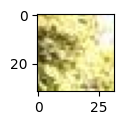

Label: ['0 0.99647635']


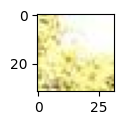

Label: ['0 0.98901635']


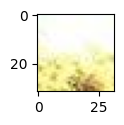

Label: ['0 0.9996834']


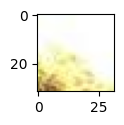

Label: ['0 0.99181014']


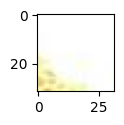

Label: ['0 0.9997228']


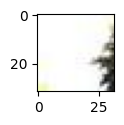

Label: ['0 0.9371584']


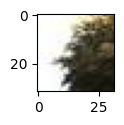

Label: ['0 0.9746606']


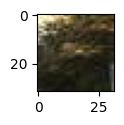

Label: ['0 0.99837387']


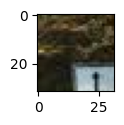

Label: ['0 0.8346956']


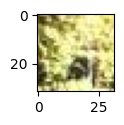

Label: ['0 0.9999074']


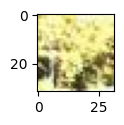

Label: ['0 0.9954189']


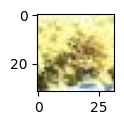

Label: ['0 0.98909503']


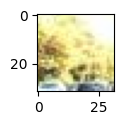

Label: ['0 0.97259694']


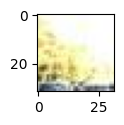

Label: ['2 0.8143689']


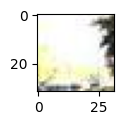

Label: ['0 0.9894667']


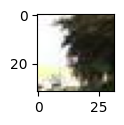

Label: ['0 0.9905682']


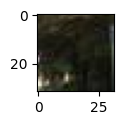

Label: ['0 0.9999995']


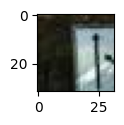

Label: ['1 0.9488211']


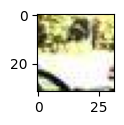

Label: ['0 0.99553525']


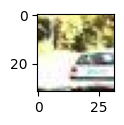

Label: ['0 0.9960033']


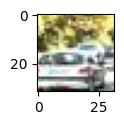

Label: ['2 0.9994324']


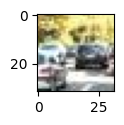

Label: ['2 0.99515']


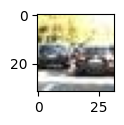

Label: ['2 0.99977285']


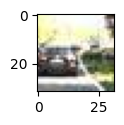

Label: ['0 0.9766792']


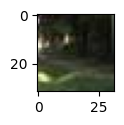

Label: ['0 0.9415227']


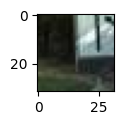

Label: ['0 0.8670087']


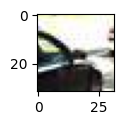

Label: ['1 0.7602939']


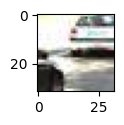

Label: ['1 0.96559304']


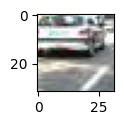

Label: ['0 0.68248975']


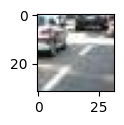

Label: ['1 0.8163575']


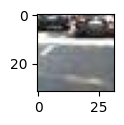

Label: ['1 0.9997694']


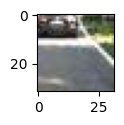

Label: ['0 0.99708706']


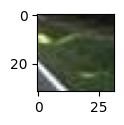

Label: ['0 0.9005259']


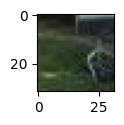

Label: ['0 0.9969702']


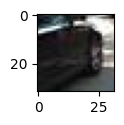

Label: ['0 0.6809596']


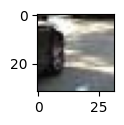

Label: ['1 0.83415127']


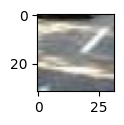

Label: ['1 0.93248767']


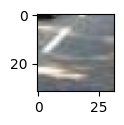

Label: ['0 0.6389758']


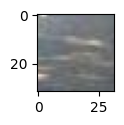

Label: ['0 0.8335995']


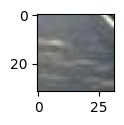

Label: ['1 0.992957']


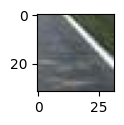

Label: ['0 0.98150164']


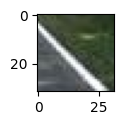

Label: ['0 0.91564035']


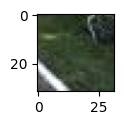

0.6888888888888889

In [ ]:
test = sliding_predictions(perceptron, windows_array)
test

**Are you satisfied with the detection results?**

Next, we'll try some different image recognition models. Hopefully, we can get a better detector!

# Milestone 3. Exploring Convolutional Neural Networks


Convolutional neural networks tend to perform much better on images, compared with the perceptron model.

So, how is a convolutional neural network specified in tensorflow/keras? Let's walk through this!

### Exercise (Coding) | Building a CNN model


Our convolutional neural network is specified like:

```python
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(__, __, __)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = NUM_OUTPUTS, activation = 'softmax'))
```

We see that we have a convolution layer that takes in our inputs, and then 2 dense layers. Overall this is a 3-layer network.

After specifying the network, we can compile it and train it just like before! Note:
* we want loss to be `'categorical_crossentropy'`
* our optimizer will be  `optimizers.SGD(learning_rate=1e-3, momentum=0.95)`
* our metric is `['accuracy']`

In [ ]:
### YOUR CODE HERE

# specify the network
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 3, activation = 'softmax'))
# compile the network
cnn.compile(loss='categorical_crossentropy',
            optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.95),
            metrics=['accuracy'])
### END CODE

In [ ]:
labels.shape

(45,)

Once we've compiled the network, train it for 20 epochs.



Epoch 1/20
469/469 [==============================] - 3s 6ms/step - loss: 6.5642e-04 - accuracy: 1.0000 - val_loss: 0.6776 - val_accuracy: 0.8593
Epoch 2/20
 22/469 [>.............................] - ETA: 2s - loss: 5.8620e-04 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 2s 5ms/step - loss: 6.2960e-04 - accuracy: 1.0000 - val_loss: 0.6811 - val_accuracy: 0.8600
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 6.0861e-04 - accuracy: 1.0000 - val_loss: 0.6822 - val_accuracy: 0.8603
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 5.8688e-04 - accuracy: 1.0000 - val_loss: 0.6836 - val_accuracy: 0.8607
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 5.6583e-04 - accuracy: 1.0000 - val_loss: 0.6885 - val_accuracy: 0.8607
Epoch 6/20
469/469 [==============================] - 3s 5ms/step - loss: 5.4887e-04 - accuracy: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.8610
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 5.3149e-04 - accuracy: 1.0000 - val_loss: 0.6919 - val_accuracy: 0.8603
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 5.1359e-04 - accuracy: 1.0000 - val_loss: 0.6930 - val_accura

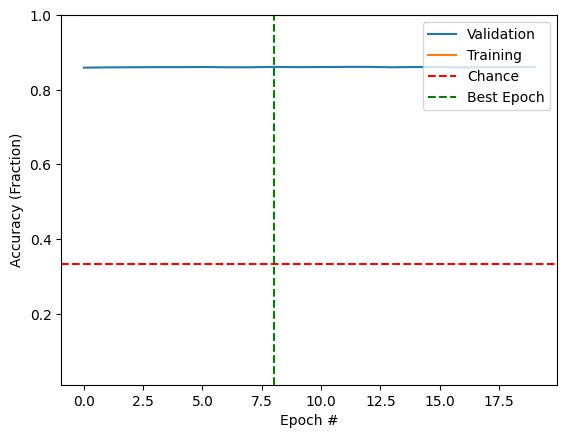

In [ ]:
### YOUR CODE HERE
history = cnn.fit(X_train_norm, y_train_onehot, epochs=20, validation_data=(X_test_norm, y_test_onehot), shuffle=True, callbacks=[monitor])
plot_acc(history)
### END CODE

And see how well it did!

In [ ]:
### YOUR CODE HERE
XW = normalize(windows_array)
initial_pred = cnn.predict(XW)
y_pred_probs = np.max(initial_pred, axis=1)
y_pred = initial_pred.argmax(axis=1)
y_pred_probs, y_pred, y_pred_probs.shape, y_pred.shape
### END CODE

2/2 [==============================] - 0s 43ms/step


(array([0.9999999 , 0.9999956 , 0.9987545 , 0.996855  , 0.9981194 ,
        0.9873426 , 0.97668695, 0.9954585 , 0.9999964 , 0.9984511 ,
        0.99980944, 0.60165584, 0.7900481 , 0.57164174, 0.5419141 ,
        0.9999999 , 0.99999905, 0.54473406, 0.97884   , 0.938771  ,
        0.99997187, 0.9999634 , 0.99205583, 0.913174  , 0.999493  ,
        0.9999192 , 0.9460826 , 0.9996865 , 0.9708368 , 0.98846483,
        0.9793289 , 0.99997723, 1.        , 0.99999976, 0.99994934,
        0.9999777 , 0.9114748 , 0.9696445 , 0.9440032 , 0.5804299 ,
        0.99872345, 0.98380363, 0.99144125, 1.        , 0.99680185],
       dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2,
        2, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0]),
 (45,),
 (45,))

Nice training accuracy!

**Do you think this CNN model is better than the perceptron?**

**Does the model still overfit?**

Same as how we got a simple vehicle detector by applying the trained perceptron to classifying the sliding windows, we can apply our new model as well. Just call the function `sliding_predictions(model, windows, threshold)` with our new model `cnn`!

2/2 [==============================] - 0s 8ms/step
Label: ['0 0.96381485']


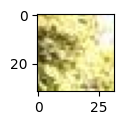

Label: ['0 0.99647635']


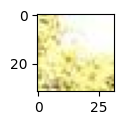

Label: ['0 0.98901635']


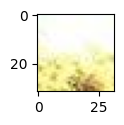

Label: ['0 0.9996834']


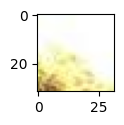

Label: ['0 0.99181014']


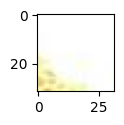

Label: ['0 0.9997228']


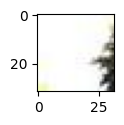

Label: ['0 0.9371584']


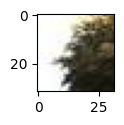

Label: ['0 0.9746606']


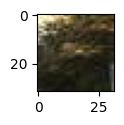

Label: ['0 0.99837387']


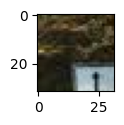

Label: ['0 0.8346956']


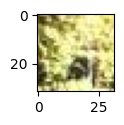

Label: ['0 0.9999074']


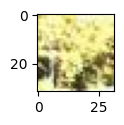

Label: ['0 0.9954189']


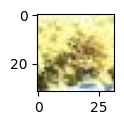

Label: ['0 0.98909503']


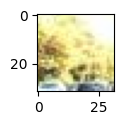

Label: ['0 0.97259694']


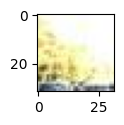

Label: ['2 0.8143689']


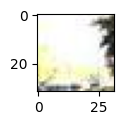

Label: ['0 0.9894667']


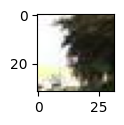

Label: ['0 0.9905682']


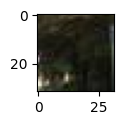

Label: ['0 0.9999995']


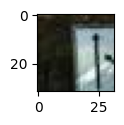

Label: ['1 0.9488211']


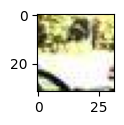

Label: ['0 0.99553525']


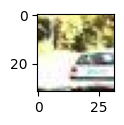

Label: ['0 0.9960033']


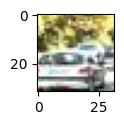

Label: ['2 0.9994324']


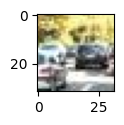

Label: ['2 0.99515']


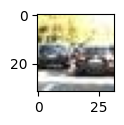

Label: ['2 0.99977285']


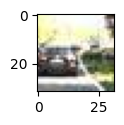

Label: ['0 0.9766792']


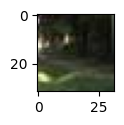

Label: ['0 0.9415227']


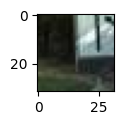

Label: ['0 0.8670087']


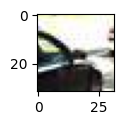

Label: ['1 0.7602939']


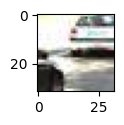

Label: ['1 0.96559304']


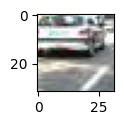

Label: ['0 0.68248975']


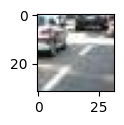

Label: ['1 0.8163575']


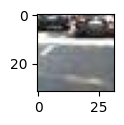

Label: ['1 0.9997694']


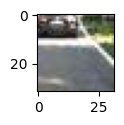

Label: ['0 0.99708706']


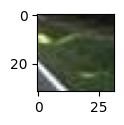

Label: ['0 0.9005259']


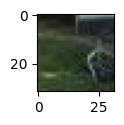

Label: ['0 0.9969702']


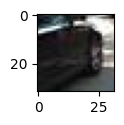

Label: ['0 0.6809596']


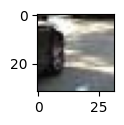

Label: ['1 0.83415127']


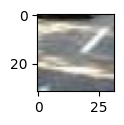

Label: ['1 0.93248767']


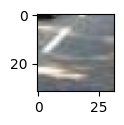

Label: ['0 0.6389758']


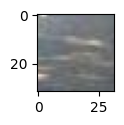

Label: ['0 0.8335995']


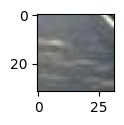

Label: ['1 0.992957']


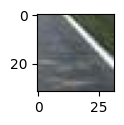

Label: ['0 0.98150164']


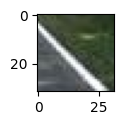

Label: ['0 0.91564035']


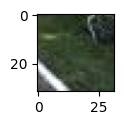

0.6888888888888889


In [ ]:
### YOUR CODE HERE
accuracy = sliding_predictions(cnn, windows_array)
print(accuracy)
### END CODE

Is this CNN model better than the perceptron?


# Milestone 4. Expert models: Transfer learning

For all of the machine learning we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world.

And, despite their cuteness, these babies require **a lot of education** to do much anything useful.

Unfortunately, our training manual is pretty small compared to all the things in the big wide world, so just training on our manual is going to be inherently limited.


Luckily, there are **non-babies** (who we will refer to as experts) who have been out in the world for a long time! While these non-babies haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly.

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**.

## Activity 4a. Transfer learning for vehicle recognition


### Instructor-Led Discussion

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 3 different categories.

![](https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/ImageNet.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times.

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR images. Hopefully, their experience with those 14 million images will help it understand object detection.

### Exercise (Coding) | Within a student group

Let's tap an expert model to help us out with our object detection!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`



Afterwards, see if you can get 95% validation accuracy with your model!

In [ ]:
### YOUR CODE HERE
transfer = TransferClassifier(name = 'ResNet50')
transfer_pred = transfer.predict(XW)
print(np.max(transfer_pred, axis=1), np.argmax(transfer_pred, axis=1))
print(f'Accuracy: {np.argmax(transfer_pred, axis=1) == labels}')
### END CODE

2/2 [==============================] - 1s 13ms/step
[0.7191189  0.81506246 0.8559735  0.8242599  0.83621496 0.75848925
 0.81139946 0.7876903  0.7780441  0.77697414 0.77060676 0.88262653
 0.882279   0.81147    0.82152724 0.7999068  0.8478298  0.7902172
 0.78599405 0.6666222  0.8403352  0.83246    0.9311514  0.85868084
 0.8546083  0.8427389  0.73377484 0.8930769  0.89015394 0.8953876
 0.8518934  0.81207395 0.7691937  0.96179616 0.8771068  0.8233987
 0.72377676 0.7067227  0.91251343 0.72807354 0.80692    0.87589246
 0.89053714 0.9453376  0.8885219 ] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
Accuracy: [False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
 False False False  True  True  True  True  True  True False False False
  True False False False False False False False False]



## Activity 4b. Transfer learning in tensorflow/keras

If you want to see how to implement transfer learning in tensorflow/keras, you can try this exercise!


### Exercise (Coding)


First, we will check out our keras toolbox's prebuilt machines and get VGG16.

Let's now load up VGG16. We only want the convolution layers of the model - that is, the layers that are most responsible for giving the model its visual understanding. The 'Dense/Fully Connected (FC)' layers are thought to be more specific to the ImageNet challenge.

In [ ]:
# load the vgg network that is an 'expert' at 'imagenet' but do not include the FC layers
vgg_expert = VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))

Now, we're going to plug the VGG expert into a custom model. To do this, we do the following:

In [ ]:
vgg_model = Sequential()
vgg_model.add(vgg_expert)

We want to add custom layers to our model... specifically,

```python
GlobalAveragePooling2D() # helps our vgg expert
Dense(1024, activation = 'relu') # we've seen dense before!
Dropout(0.3) # we've experimented with dropout before!
Dense(512, activation = 'relu')
Dropout(0.3)
Dense(3, activation = 'softmax') # our output layer!
```


## Instructor-Led Discussion: Why do we add these models to the end of the network?

In [ ]:
# add the extra layers here
### YOUR CODE HERE

### END CODE

And finally compile it with
* loss: `categorical_crossentropy`
* optimizer: `optimizers.SGD(learning_rate = 1e-4, momentum = 0.95)`
* metrics: `accuracy`


In [ ]:
# compile our model
### YOUR CODE HERE

### END CODE

Finally, hand our model its training manual, and let it train.

In [ ]:
### YOUR CODE HERE

### END CODE

Give your model its test, and see how well it works

In [ ]:
### YOUR CODE HERE

### END CODE

Let's apply our expert model for vehicle detection!

In [ ]:
acc = sliding_predictions(vgg_model, windows, threshold=0.9)
print("The accuracy is {}".format(acc))

### Exercise (Discussion)



*   Do you think the CNN model and the pre-trained VGG model are better than our simple perceptron? Why?
*   Does the detector work better as we changed the image classifier?
*   How do you like our vehicle detector, a combination of sliding windows and a vehicle classifier? Can you list some weaknesses?
*   Share with your classmates if you have ideas about a better detection algorithm!



